$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$

# Control a Marble with Reinforcement Learning

Fawad Ahmad

## $Overview$

In this assignment, I have modified the reinforcement learning code used to solve the dynamic marble problem.  I have solved a more complex version of the marble problem in which a goal position is specified as a new state variable. First I have trained my program for any random goal then I have shown the goal outputs for the values from 0 to 10. After that I have observed the final output by varying the input parameters like gammam nTrials, nStepsPerTrial, nSCGIterations, and finalEpsilon. Then I have taken graphs of goals 1 ,5 and 9 to look into the variations when we change the goals given that the qnet is same.

## $Functions$ $For$ $the$ $Program$

In [1]:
import neuralnetworksbylayer as nn
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import copy

%matplotlib inline

To define a reinforcement learning problem, we need functions that return

* initial the state of the environment,
* a next state given a current state and an action,
* a reinforcement value, and
* an action to take, given the current state. For this we define an $\epsilon$-greedy policy.

Let's first define the set of valid actions.  For our simple one-dimensional marble problem, we can push left, right, or not push at all.

In [2]:
validActions = np.array([ -1, 0, 1])

Following is the Discription of functions.
* $initialState$ is to get the starting parameters so i have included "count" and "count1" which determines that whether goal has to be random or given from main program. We want both the requirements as we have to show all the graphs from 0 to 10.
* $nextState$ is to get the next state in terms of position and velocity.
* $reinforcement$ is to look for the goal and current position difference and reinforce accordingly.
* $policy$ is to get new action randomly or by looking into the qnet for a good action.
* $makeSamples$ is to get all the samples considering one starting point so that when we give it to the system, it learns better.
* $plotStatus$ is to generate different plots to show reinforcements,actions,NN, MaxQ and relation of position with velocity.
* $testIt$ is to generate the testing results with different inputs.

In [3]:
def initialState(count,count1,goal):
    global position 
    if count == 0 and count1 ==0:
        position = np.random.randint(0,9)
    if count == 1 and count1 ==0:
        position = goal
    #print(position)
    return np.array([10*np.random.random_sample(), 3*(0.5-np.random.random_sample()),position ])

def nextState(s,a):
    s = copy.copy(s)   # s[0] is position, s[1] is velocity. a is -1, 0 or 1
    deltaT = 0.1                           # Euler integration time step
    s[0] += deltaT * s[1]                  # Update position
    s[1] += deltaT * (2 * a - 0.2 * s[1])  # Update velocity. Includes friction
    if s[0] < 0:        # Bound next position. If at limits, set velocity to 0.
        s = np.array([0,0,s[2]])
    elif s[0] > 10:
        s = np.array([10,0,s[2]])
    return s

def reinforcement(s):  # s is new state
    goal = s[2]
    return 0 if abs(s[0]-goal) < 1 else -0.1

def policy(qnet, state, epsilon):
    if np.random.rand(1) < epsilon:
        actioni = np.random.randint(validActions.shape[0])
    else:
        inputs = np.hstack(( np.tile(state, (validActions.shape[0], 1)), validActions.reshape((-1,1))))
        qs = qnet.use(inputs)
        actioni = np.argmax(qs)
    return validActions[actioni]

In [4]:
def makeSamples(qnet, nStepsPerStart,count,count1,goal):
    samples = []
    state = initialState(count,count1,goal)
    act = policy(qnet, state, epsilon)
    oldact = act
    for iStep in range(nStepsPerStart):
        newState = nextState(state, act)
        r = reinforcement(newState)
        newAct = policy(qnet, newState, epsilon)
        # SARSA
        samples.append(state.tolist() + [act, r] + newState.tolist() + [newAct])
        state = newState
        oldact = act
        act = newAct
    return np.array(samples)

In [5]:
def plotStatus(qnet, X, R, trial, epsilonTrace, rtrace, count):
    plt.subplot(4,3,1)
    plt.plot(epsilonTrace[:trial+1])
    plt.ylabel("Random Action Probability ($\epsilon$)")
    plt.ylim(0,1)
    plt.subplot(4,3,2)
    plt.plot(X[:,0])
    plt.plot([0,X.shape[0]], [count,count],'--',alpha=0.5,lw=5)
    plt.ylabel("$x$")
    plt.ylim(-1,11)
    #qs = [[qnet.use([s,0,a]) for a in actions] for s in range(11)]
    qs = qnet.use(np.array([[s,0,count,a] for a in validActions for s in range(11)]))
    #print np.hstack((qs,-1+np.argmax(qs,axis=1).reshape((-1,1))))
    plt.subplot(4,3,3)
    acts = ["L","0","R"]
    actsiByState = np.argmax(qs.reshape((len(validActions),-1)),axis=0)
    for i in range(11):
        plt.text(i,0,acts[actsiByState[i]])
        plt.xlim(-1,11)
        plt.ylim(-1,1)
    plt.text(2,0.2,"Policy for Zero Velocity")
    plt.axis("off")
    plt.subplot(4,3,4)
    plt.plot(rtrace[:trial+1],alpha=0.5)
    #plt.plot(np.convolve(rtrace[:trial+1],np.array([0.02]*50),mode='valid'))
    binSize = 20
    if trial+1 > binSize:
        # Calculate mean of every bin of binSize reinforcement values
        smoothed = np.mean(rtrace[:int(trial/binSize)*binSize].reshape((int(trial/binSize),binSize)),axis=1)
        plt.plot(np.arange(1,1+int(trial/binSize))*binSize,smoothed)
    plt.ylabel("Mean reinforcement")
    plt.subplot(4,3,5)
    plt.plot(X[:,0],X[:,1])
    plt.plot(X[0,0],X[0,1],'o')
    plt.xlabel("$x$")
    plt.ylabel("$\dot{x}$")
    plt.fill_between([count,count],[-5,-5],[5,5],color="red",alpha=0.3)
    plt.xlim(-1,11)
    plt.ylim(-5,5)
    plt.subplot(4,3,6)
    qnet.draw(["$x$","$\dot{x}$","$a$"],["Q"])

    plt.subplot(4,3,7)
    n = 20
    positions = np.linspace(0,10,n)
    velocities =  np.linspace(-5,5,n)
    xs,ys = np.meshgrid(positions,velocities)
    #states = np.vstack((xs.flat,ys.flat)).T
    #qs = [qnet.use(np.hstack((states,np.ones((states.shape[0],1))*act))) for act in actions]
    xsflat = xs.flat
    ysflat = ys.flat
    qs = qnet.use(np.array([[xsflat[i],ysflat[i],count,a] for a in validActions for i in range(len(xsflat))]))
    #qs = np.array(qs).squeeze().T
    qs = qs.reshape((len(validActions),-1)).T
    qsmax = np.max(qs,axis=1).reshape(xs.shape)
    cs = plt.contourf(xs,ys,qsmax)
    plt.colorbar(cs)
    plt.xlabel("$x$")
    plt.ylabel("$\dot{x}$")
    plt.title("Max Q")
    plt.subplot(4,3,8)
    acts = np.array(validActions)[np.argmax(qs,axis=1)].reshape(xs.shape)
    cs = plt.contourf(xs,ys,acts,[-2, -0.5, 0.5, 2])
    plt.colorbar(cs)
    plt.xlabel("$x$")
    plt.ylabel("$\dot{x}$")
    plt.title("Actions")

    s = plt.subplot(4,3,10)
    rect = s.get_position()
    ax = Axes3D(plt.gcf(),rect=rect)
    ax.plot_surface(xs,ys,qsmax,cstride=1,rstride=1,cmap=cm.viridis,linewidth=0)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$\dot{x}$")
    #ax.set_zlabel("Max Q")
    plt.title("Max Q")

    s = plt.subplot(4,3,11)
    rect = s.get_position()
    ax = Axes3D(plt.gcf(),rect=rect)
    ax.plot_surface(xs,ys,acts,cstride=1,rstride=1,cmap=cm.viridis,linewidth=0)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$\dot{x}$")
    #ax.set_zlabel("Action")
    plt.title("Action")

def testIt(qnet,nTrials,nStepsPerTrial,count):
    xs = np.linspace(0,10,nTrials)
    plt.subplot(4,3,12)
    for x in xs:
        s = [x,0,count] ## 0 velocity
        xtrace = np.zeros((nStepsPerTrial,3))
        for step in range(nStepsPerTrial):
            a = policy(qnet, s, 0.0)  # epsilon = 0
            s = nextState(s,a)
            xtrace[step,:] = s
        plt.plot(xtrace[:,0],xtrace[:,1])
        plt.xlim(-1,11)
        plt.ylim(-5,5)
        plt.plot([count,count],[-5,5],'--',alpha=0.5,lw=5)
        plt.ylabel('$\dot{x}$')
        plt.xlabel('$x$')
        plt.title('State Trajectories for $\epsilon=0$')

### $Parameters$ $for$ $network$  $architecture$

In [6]:
gamma = 0.999
nTrials = 300
nStepsPerTrial = 500
nSCGIterations = 30
finalEpsilon = 0.01
epsilonDecay = np.exp(np.log(finalEpsilon)/(nTrials))  # to produce this final value
nh = [5,5]
qnet = nn.NeuralNetwork([4] + nh + [1])  # [3, 5, 5, 1]
qnet.setInputRanges(( (0, 10), (-3, 3),(0,10), (-1,1)))

## $Program$ $for$ $random$ $goal$

This program sets count and count1 to zero which makes it take random goals in the initial state function.

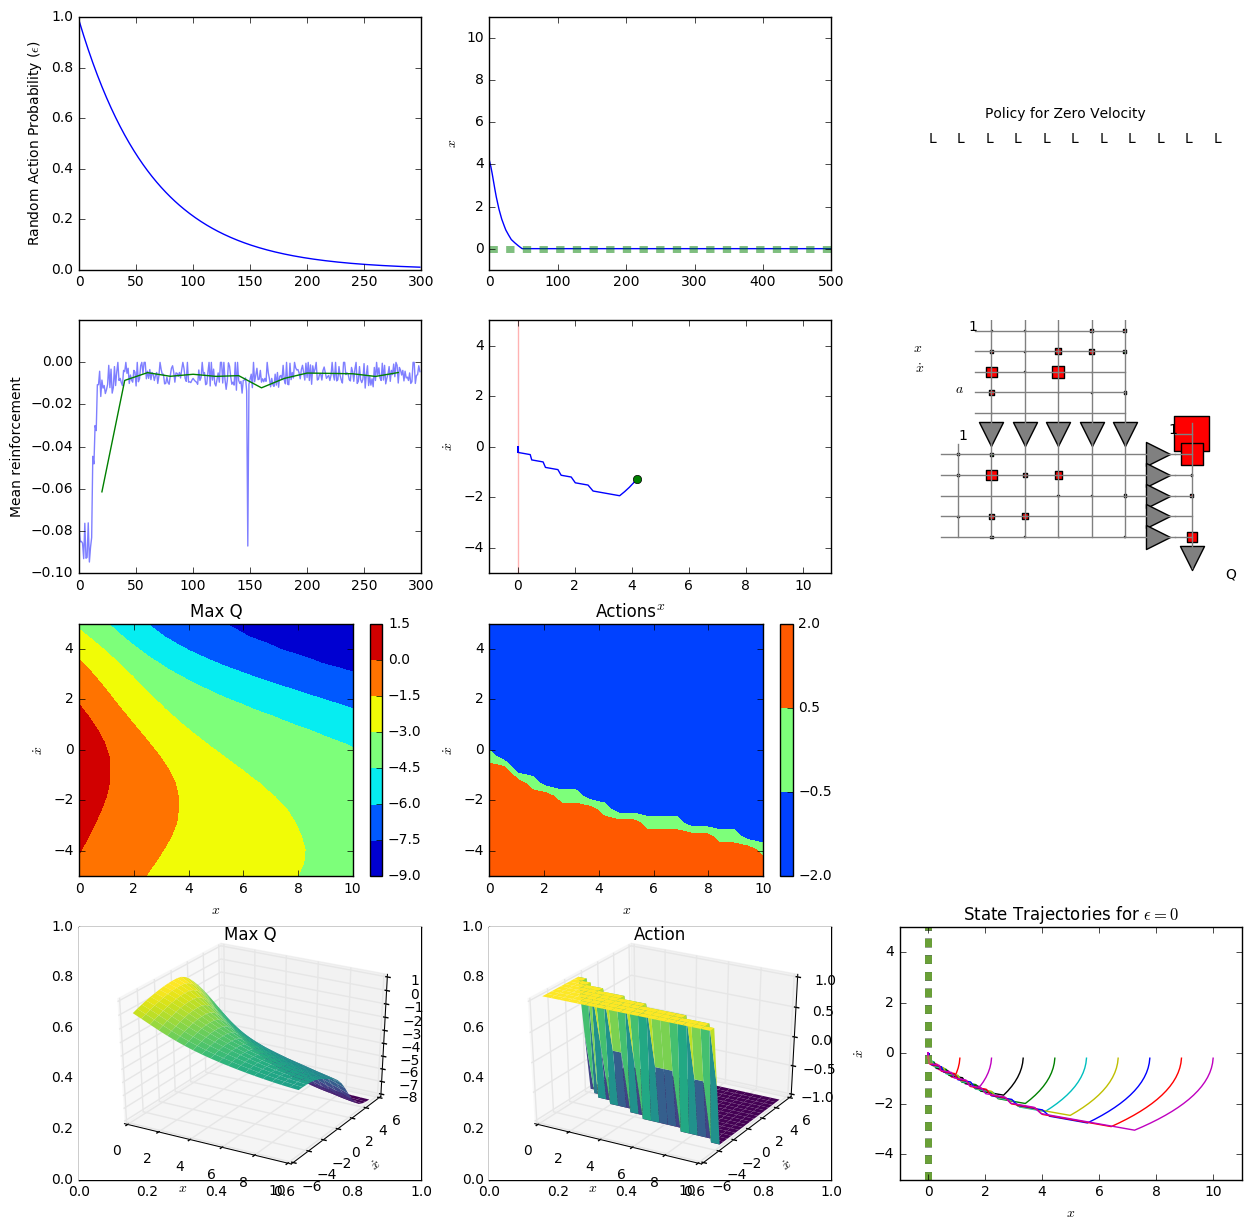

In [8]:
####### For Random !! ######
fig = plt.figure(figsize=(15,15))

epsilon = 1
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
count = 0
count1 = 0
for trial in range(nTrials):

    #Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    samples = makeSamples(qnet, nStepsPerTrial,count,count1,0)
    count = 5
    count1 = 5
    #count = count + 1
    ns = 2
    na = 2
    X = samples[:, :ns+na]
    R = samples[:, ns+na:ns+na+1]
    nextX = samples[:, ns+na+1:]
    nextQ = qnet.use(nextX)
    print(samples[0,2])
    qnet.train(X, R + gamma * nextQ, nIterations = nSCGIterations)

    # Decay epsilon
    epsilon *= epsilonDecay
    # epsilon = max(0.01, epsilon)

    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    rtrace[trial] = np.mean(R)

    if trial % (nTrials//10) == 0 or trial == nTrials-1:
        plt.clf()
        plotStatus(qnet, X, R, trial,epsilonTrace,rtrace,samples[0,2])
        testIt(qnet,10,500,samples[0,2])
        clear_output(wait=True)
        display(fig);

    # print('Trial',trial,'mean R',np.mean(R))
clear_output(wait=True)

### $Analysis$:
If we keep on running the program, it take different goals randomly and train the system on these goals which sometimes show different results which depends on parameters of network which i will discuss later in this document.

## $Graphs$ $by$ $changing$ $parameters$:
Following are the graphs by changing different parameters.

###  $Results$ $by$ $changing$ $architecture (nh)$

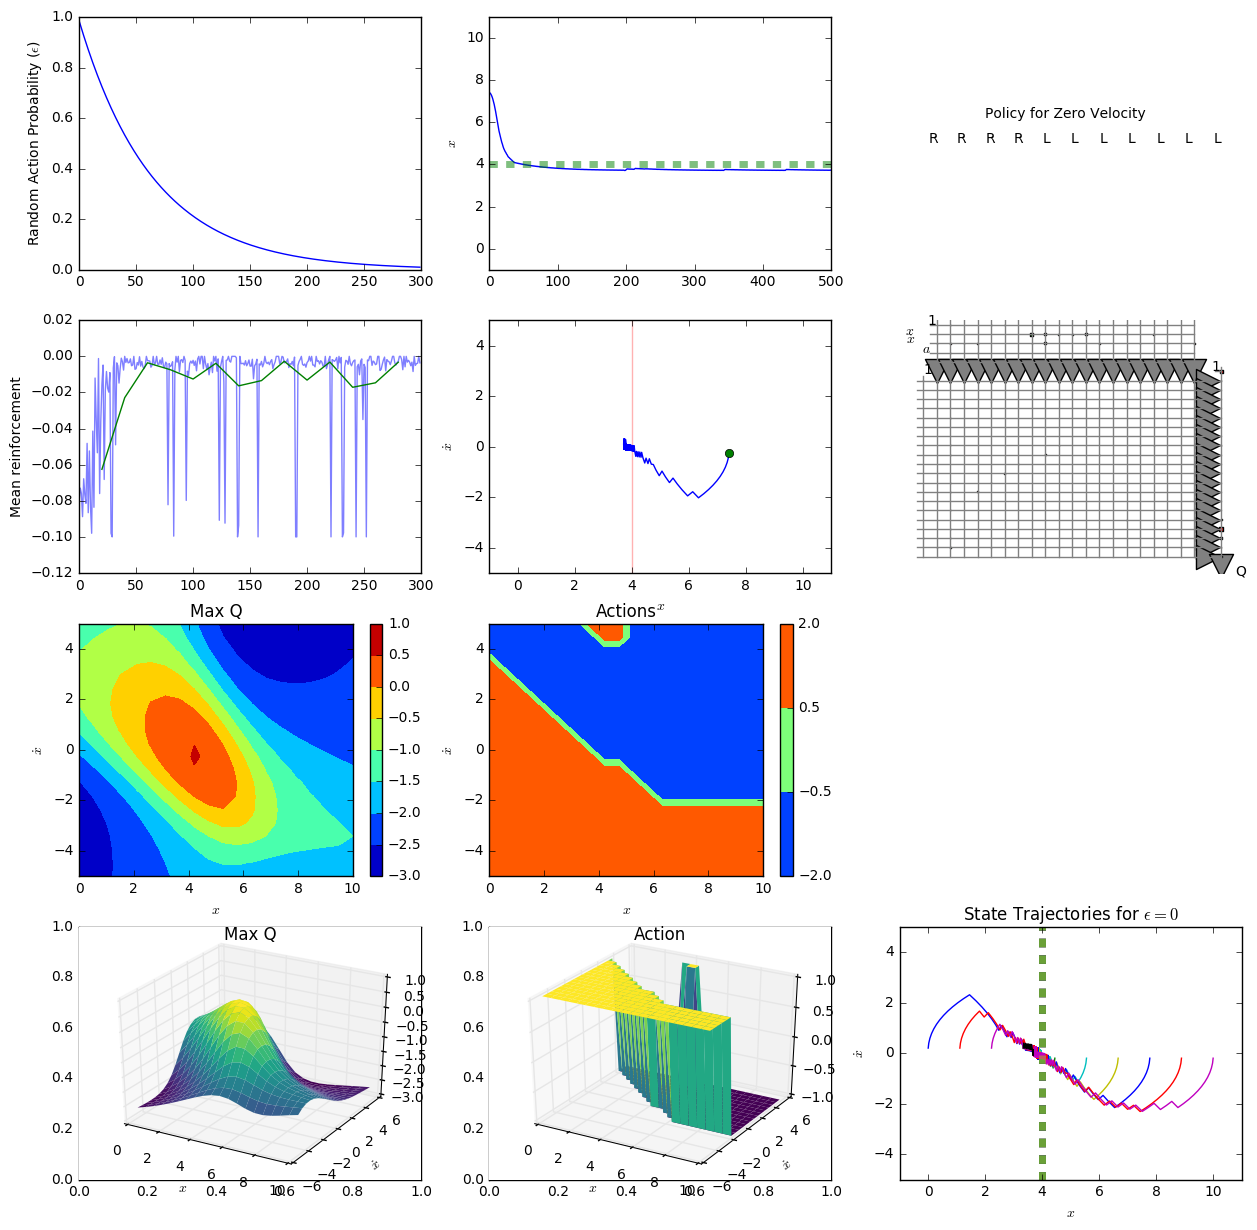

In [6]:
gamma = 0.999
nTrials = 300
nStepsPerTrial = 500
nSCGIterations = 30
finalEpsilon = 0.01
epsilonDecay = np.exp(np.log(finalEpsilon)/(nTrials))  # to produce this final value
nh = [20,20]
qnet = nn.NeuralNetwork([4] + nh + [1])  # [3, 5, 5, 1]
qnet.setInputRanges(( (0, 10), (-3, 3),(0,10), (-1,1)))

####### For Random !! ######
fig = plt.figure(figsize=(15,15))

epsilon = 1
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
count = 0
count1 = 0
for trial in range(nTrials):

    #Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    samples = makeSamples(qnet, nStepsPerTrial,count,count1,0)
    count = 5
    count1 = 5
    #count = count + 1
    ns = 2
    na = 2
    X = samples[:, :ns+na]
    R = samples[:, ns+na:ns+na+1]
    nextX = samples[:, ns+na+1:]
    nextQ = qnet.use(nextX)
    print(samples[0,2])
    qnet.train(X, R + gamma * nextQ, nIterations = nSCGIterations)

    # Decay epsilon
    epsilon *= epsilonDecay
    # epsilon = max(0.01, epsilon)

    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    rtrace[trial] = np.mean(R)

    if trial % (nTrials//10) == 0 or trial == nTrials-1:
        plt.clf()
        plotStatus(qnet, X, R, trial,epsilonTrace,rtrace,samples[0,2])
        testIt(qnet,10,500,samples[0,2])
        clear_output(wait=True)
        display(fig);

    # print('Trial',trial,'mean R',np.mean(R))
clear_output(wait=True)

### $Analysis $

By changing the no of hiddenlayers and hidden units, the system learns faster then usual which is being seen by the reinforcement graph and it's state trajectories graph also settles well on the given target/goal.

###  $Results$ $by$ $changing$ $gamma$

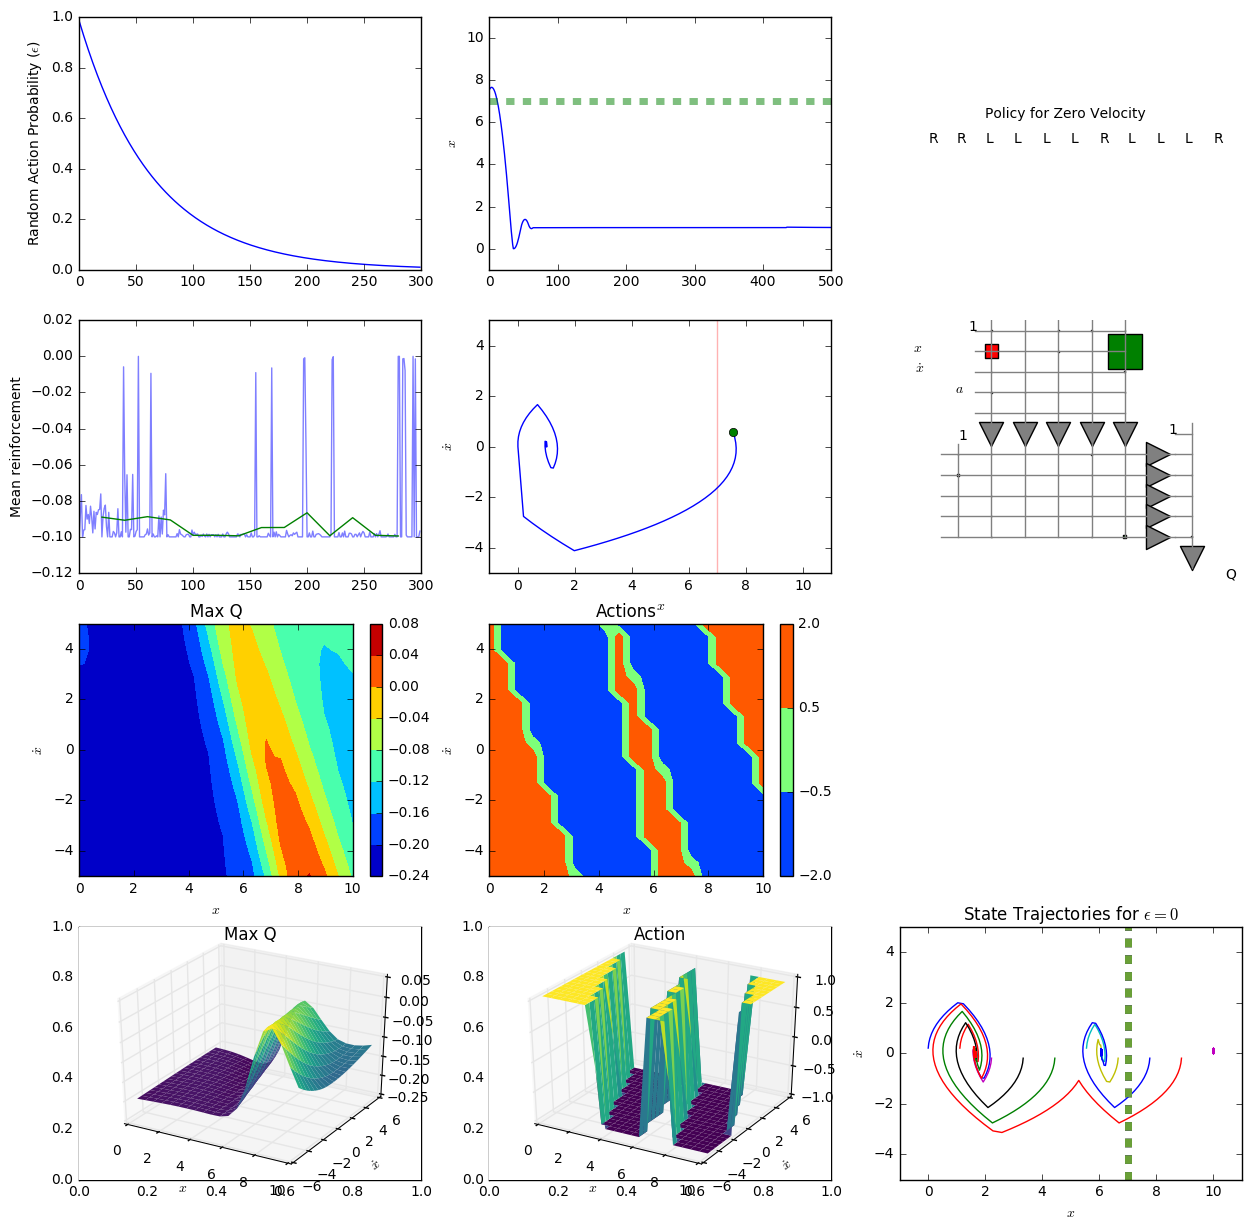

In [7]:
gamma = 0.5
nTrials = 300
nStepsPerTrial = 500
nSCGIterations = 30
finalEpsilon = 0.01
epsilonDecay = np.exp(np.log(finalEpsilon)/(nTrials))  # to produce this final value
nh = [5,5]
qnet = nn.NeuralNetwork([4] + nh + [1])  # [3, 5, 5, 1]
qnet.setInputRanges(( (0, 10), (-3, 3),(0,10), (-1,1)))

####### For Random !! ######
fig = plt.figure(figsize=(15,15))

epsilon = 1
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
count = 0
count1 = 0
for trial in range(nTrials):

    #Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    samples = makeSamples(qnet, nStepsPerTrial,count,count1,0)
    count = 5
    count1 = 5
    #count = count + 1
    ns = 2
    na = 2
    X = samples[:, :ns+na]
    R = samples[:, ns+na:ns+na+1]
    nextX = samples[:, ns+na+1:]
    nextQ = qnet.use(nextX)
    print(samples[0,2])
    qnet.train(X, R + gamma * nextQ, nIterations = nSCGIterations)

    # Decay epsilon
    epsilon *= epsilonDecay
    # epsilon = max(0.01, epsilon)

    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    rtrace[trial] = np.mean(R)

    if trial % (nTrials//10) == 0 or trial == nTrials-1:
        plt.clf()
        plotStatus(qnet, X, R, trial,epsilonTrace,rtrace,samples[0,2])
        testIt(qnet,10,500,samples[0,2])
        clear_output(wait=True)
        display(fig);

    # print('Trial',trial,'mean R',np.mean(R))
clear_output(wait=True)

### $Analysis $
Graphs shows that by decreasing the value of Gamma the system doesn't learn much and the trajectories shows circular patern which stops it from reaching the goal.

###  $Results$ $by$ $changing$ $nStepsPerTrial$ 

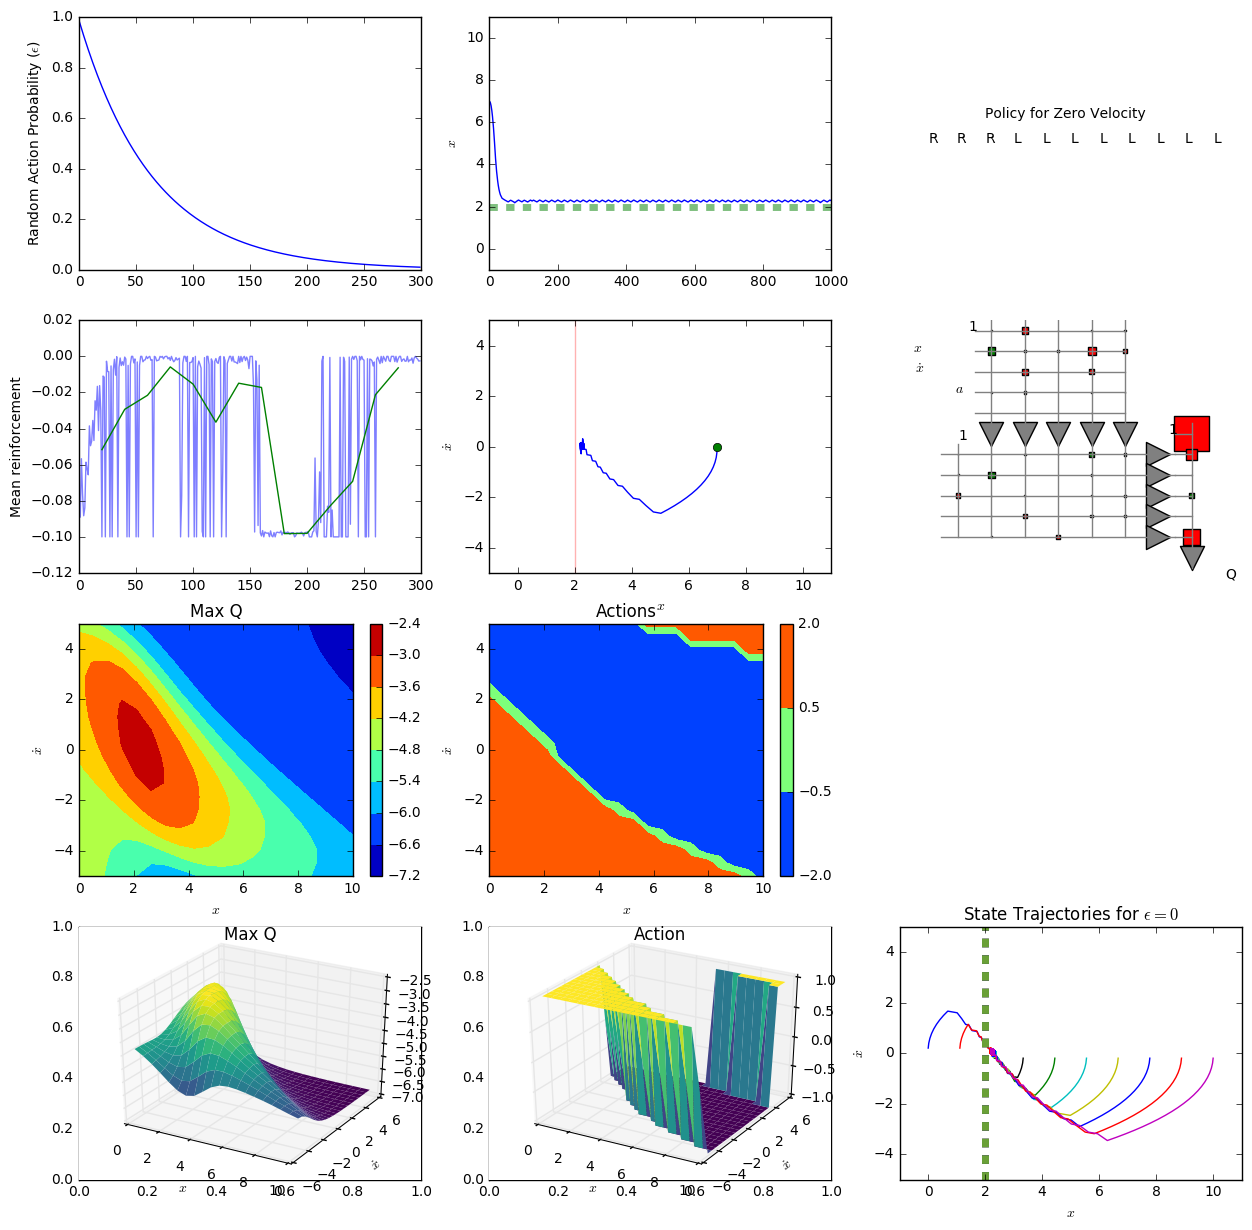

In [6]:
gamma = 0.999
nTrials = 300
nStepsPerTrial = 1000
nSCGIterations = 30
finalEpsilon = 0.01
epsilonDecay = np.exp(np.log(finalEpsilon)/(nTrials))  # to produce this final value
nh = [5,5]
qnet = nn.NeuralNetwork([4] + nh + [1])  # [3, 5, 5, 1]
qnet.setInputRanges(( (0, 10), (-3, 3),(0,10), (-1,1)))

####### For Random !! ######
fig = plt.figure(figsize=(15,15))

epsilon = 1
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
count = 0
count1 = 0
for trial in range(nTrials):

    #Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    samples = makeSamples(qnet, nStepsPerTrial,count,count1,0)
    count = 5
    count1 = 5
    #count = count + 1
    ns = 2
    na = 2
    X = samples[:, :ns+na]
    R = samples[:, ns+na:ns+na+1]
    nextX = samples[:, ns+na+1:]
    nextQ = qnet.use(nextX)
    print(samples[0,2])
    qnet.train(X, R + gamma * nextQ, nIterations = nSCGIterations)

    # Decay epsilon
    epsilon *= epsilonDecay
    # epsilon = max(0.01, epsilon)

    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    rtrace[trial] = np.mean(R)

    if trial % (nTrials//10) == 0 or trial == nTrials-1:
        plt.clf()
        plotStatus(qnet, X, R, trial,epsilonTrace,rtrace,samples[0,2])
        testIt(qnet,10,500,samples[0,2])
        clear_output(wait=True)
        display(fig);

    # print('Trial',trial,'mean R',np.mean(R))
clear_output(wait=True)

### $Analysis$
By increasing the no of nStepsPerTrial the learning is slow as compare to changing the NN parameters but the desired output is close. If we look into reinforcement graph we can also see that the learning is inconsistent too.


###  $Results$ $by$ $changing$ $nTrials $

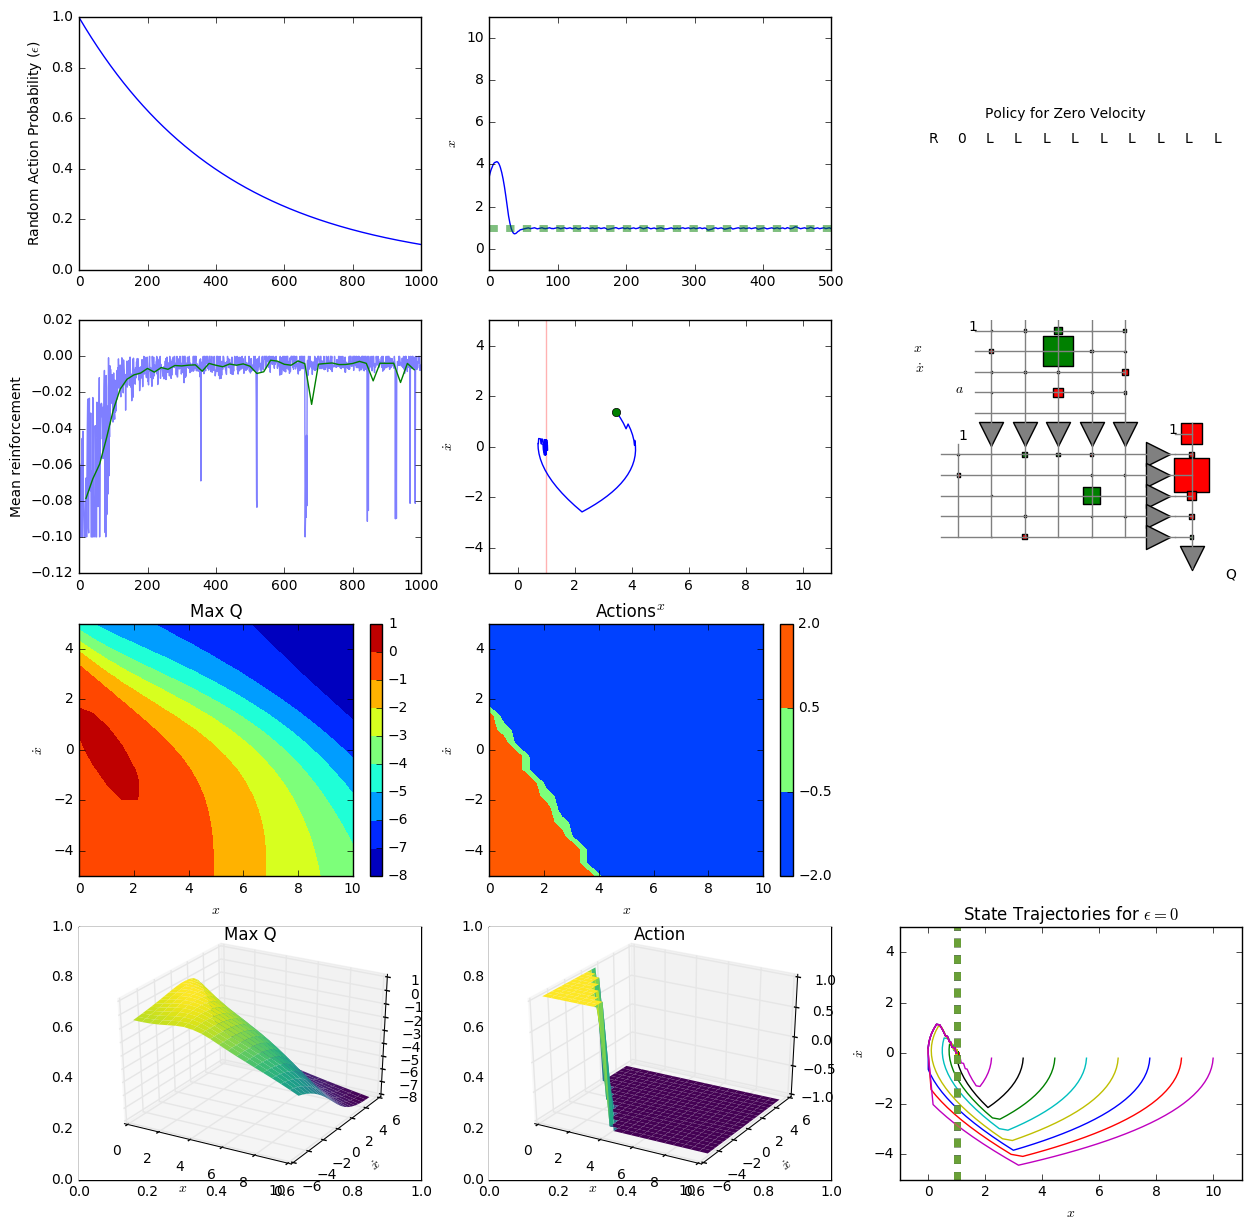

In [6]:
gamma = 0.999
nTrials = 1000
nStepsPerTrial = 500
nSCGIterations = 30
finalEpsilon = 0.1
epsilonDecay = np.exp(np.log(finalEpsilon)/(nTrials))  # to produce this final value
nh = [5,5]
qnet = nn.NeuralNetwork([4] + nh + [1])  # [3, 5, 5, 1]
qnet.setInputRanges(( (0, 10), (-3, 3),(0,10), (-1,1)))

####### For Random !! ######
fig = plt.figure(figsize=(15,15))

epsilon = 1
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
count = 0
count1 = 0
for trial in range(nTrials):

    #Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    samples = makeSamples(qnet, nStepsPerTrial,count,count1,0)
    count = 5
    count1 = 5
    #count = count + 1
    ns = 2
    na = 2
    X = samples[:, :ns+na]
    R = samples[:, ns+na:ns+na+1]
    nextX = samples[:, ns+na+1:]
    nextQ = qnet.use(nextX)
    print(samples[0,2])
    qnet.train(X, R + gamma * nextQ, nIterations = nSCGIterations)

    # Decay epsilon
    epsilon *= epsilonDecay
    # epsilon = max(0.01, epsilon)

    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    rtrace[trial] = np.mean(R)

    if trial % (nTrials//10) == 0 or trial == nTrials-1:
        plt.clf()
        plotStatus(qnet, X, R, trial,epsilonTrace,rtrace,samples[0,2])
        testIt(qnet,10,500,samples[0,2])
        clear_output(wait=True)
        display(fig);

    # print('Trial',trial,'mean R',np.mean(R))
clear_output(wait=True)

### $Analysis$
By increasing the no of trials, the system learn fast as well as the results are more accurate then changing hidden layer and units.

###  $Results$ $by$ $changing$ $finalEpsilon $

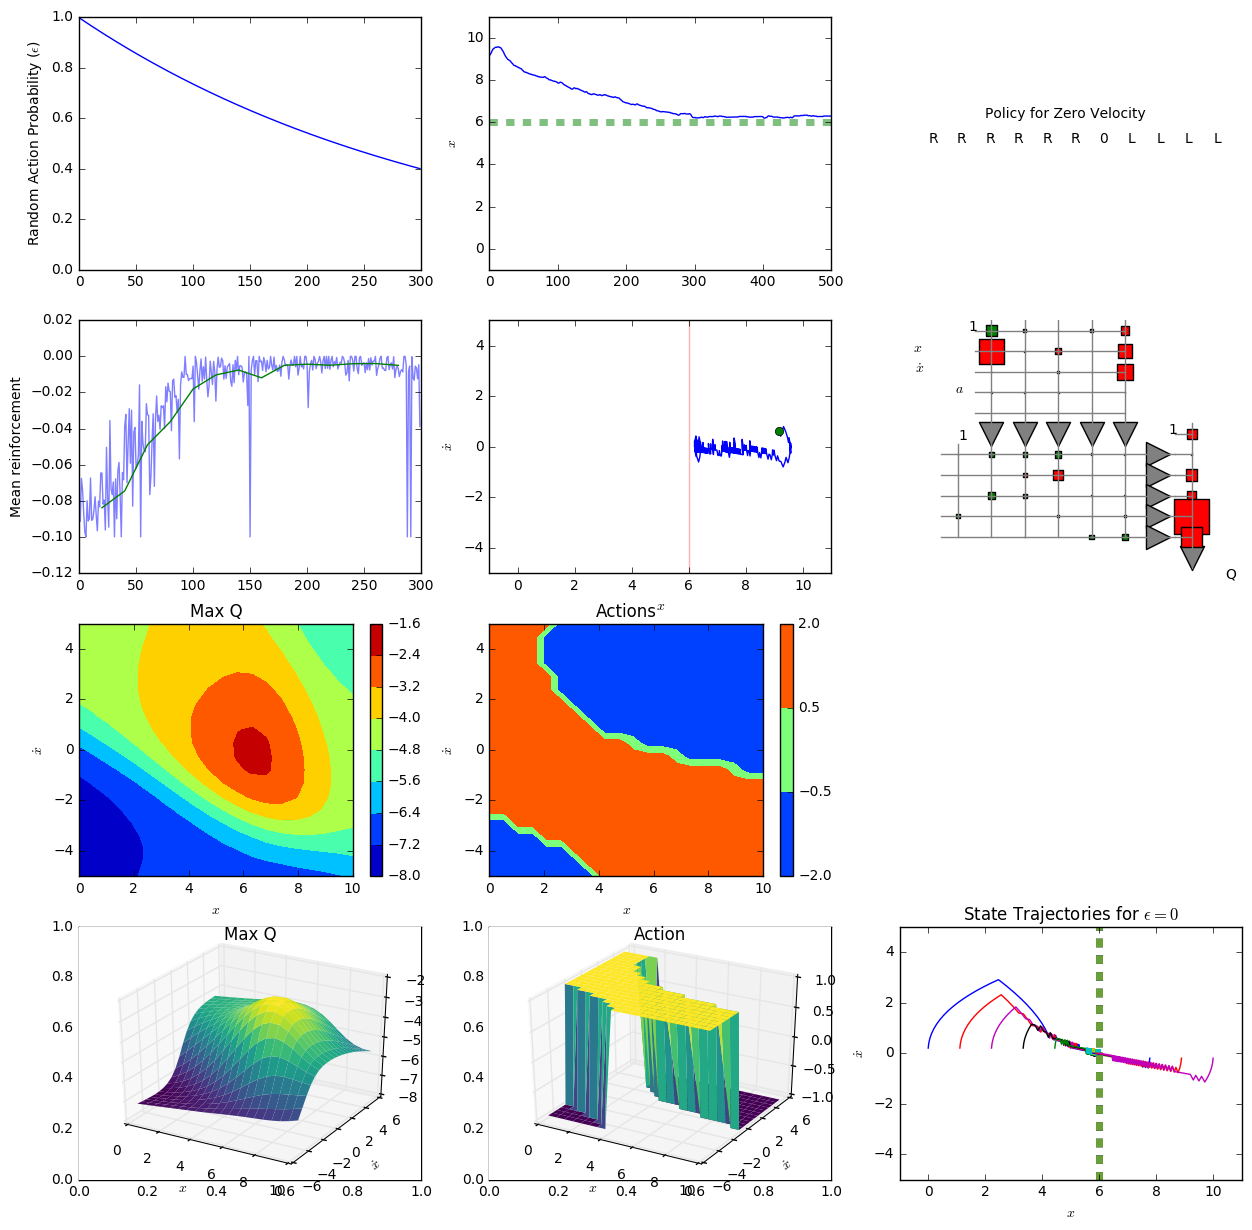

In [6]:
gamma = 0.999
nTrials = 300
nStepsPerTrial = 500
nSCGIterations = 30
finalEpsilon = 0.4
epsilonDecay = np.exp(np.log(finalEpsilon)/(nTrials))  # to produce this final value
nh = [5,5]
qnet = nn.NeuralNetwork([4] + nh + [1])  # [3, 5, 5, 1]
qnet.setInputRanges(( (0, 10), (-3, 3),(0,10), (-1,1)))

####### For Random !! ######
fig = plt.figure(figsize=(15,15))

epsilon = 1
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
count = 0
count1 = 0
for trial in range(nTrials):

    #Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    samples = makeSamples(qnet, nStepsPerTrial,count,count1,0)
    count = 5
    count1 = 5
    #count = count + 1
    ns = 2
    na = 2
    X = samples[:, :ns+na]
    R = samples[:, ns+na:ns+na+1]
    nextX = samples[:, ns+na+1:]
    nextQ = qnet.use(nextX)
    print(samples[0,2])
    qnet.train(X, R + gamma * nextQ, nIterations = nSCGIterations)

    # Decay epsilon
    epsilon *= epsilonDecay
    # epsilon = max(0.01, epsilon)

    # Rest is for plotting
    epsilonTrace[trial] = epsilon
    rtrace[trial] = np.mean(R)

    if trial % (nTrials//10) == 0 or trial == nTrials-1:
        plt.clf()
        plotStatus(qnet, X, R, trial,epsilonTrace,rtrace,samples[0,2])
        testIt(qnet,10,500,samples[0,2])
        clear_output(wait=True)
        display(fig);

    # print('Trial',trial,'mean R',np.mean(R))
clear_output(wait=True)

### $Analysis$
By increasing the final Epsilon the system needs more time or trials to learn properly which is clearly shown in the reinforcement graph. But the final output is close to desired. 

## $Program$ $to$ $show$ $10$ $graphs$

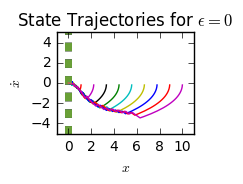

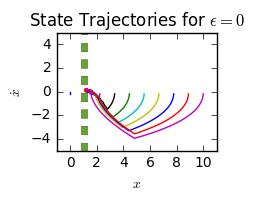

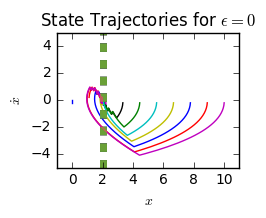

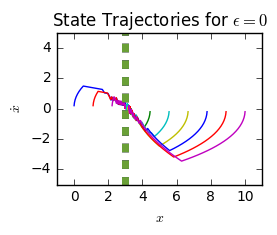

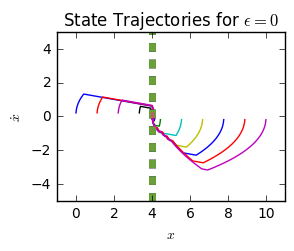

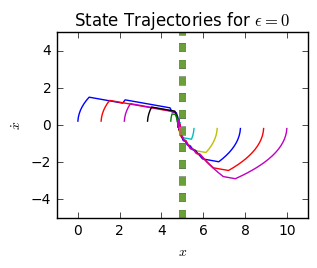

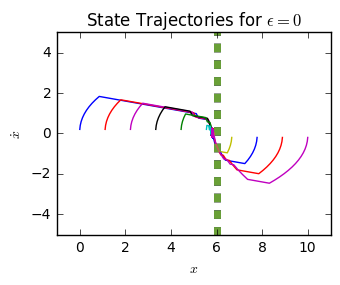

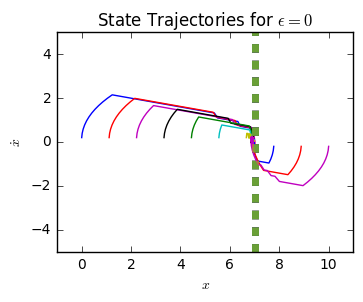

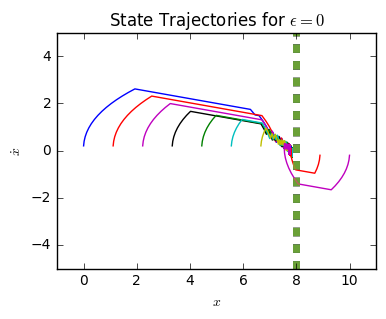

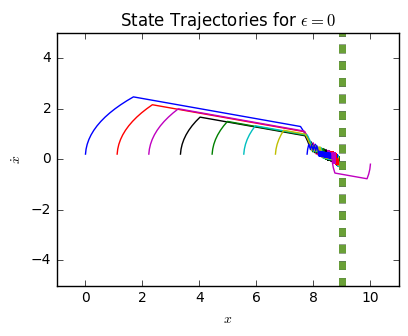

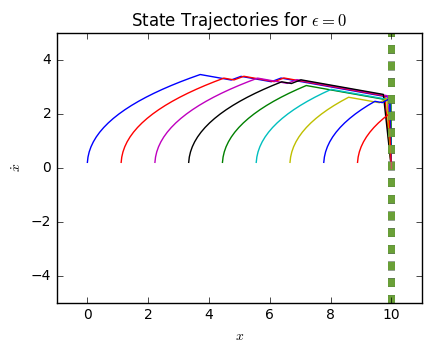

In [11]:
gamma = 0.999
nTrials = 1000
nStepsPerTrial = 500
nSCGIterations = 30
finalEpsilon = 0.01
epsilonDecay = np.exp(np.log(finalEpsilon)/(nTrials))  # to produce this final value

nh = [10,10]
qnet = nn.NeuralNetwork([4] + nh + [1])  # [3, 5, 5, 1]
qnet.setInputRanges(( (0, 10), (-3, 3),(0,10), (-1,1)))
fig = plt.figure(figsize=(15,15))

epsilon = 1
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
count = 1  # count and count1 will tell the initial state to take the given goal position
count1 = 0
nextQ = []
epsilonT = []
rtrac = []
X = []
R = []
nextX = []
for goal in range(11): # take one goal and train the system
    fig = plt.figure(figsize=(6+goal,6+goal))
    for trial in range(nTrials):

        #Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
        samples = makeSamples(qnet, nStepsPerTrial, count,count1,goal)
        ns = 2
        na = 2
        X = samples[:, :ns+na]
        R = samples[:, ns+na:ns+na+1]
        nextX = samples[:, ns+na+1:]
        nextQ = (qnet.use(nextX))
        qnet.train(X, R + gamma * nextQ, nIterations = nSCGIterations)

        # Decay epsilon
        epsilon *= epsilonDecay
        # epsilon = max(0.01, epsilon)

        # Rest is for plotting
        epsilonTrace[trial] = epsilon
        rtrace[trial] = np.mean(R)
    
    testIt(qnet,10,500,goal)
    display(fig);

        
    # print('Trial',trial,'mean R',np.mean(R))
clear_output(wait=True)

### $Analysis$:

The little bit variation in the results can be improved by changing the no's of hidden layer e.t.c. I have analysed the the graphs with different parameters and they have shown pretty good results but they requires lot of time to train but by increasing the hiddenlayers and no of trials the results are still quite better.

## $Comparision$ $of$ $3$ $graphs$

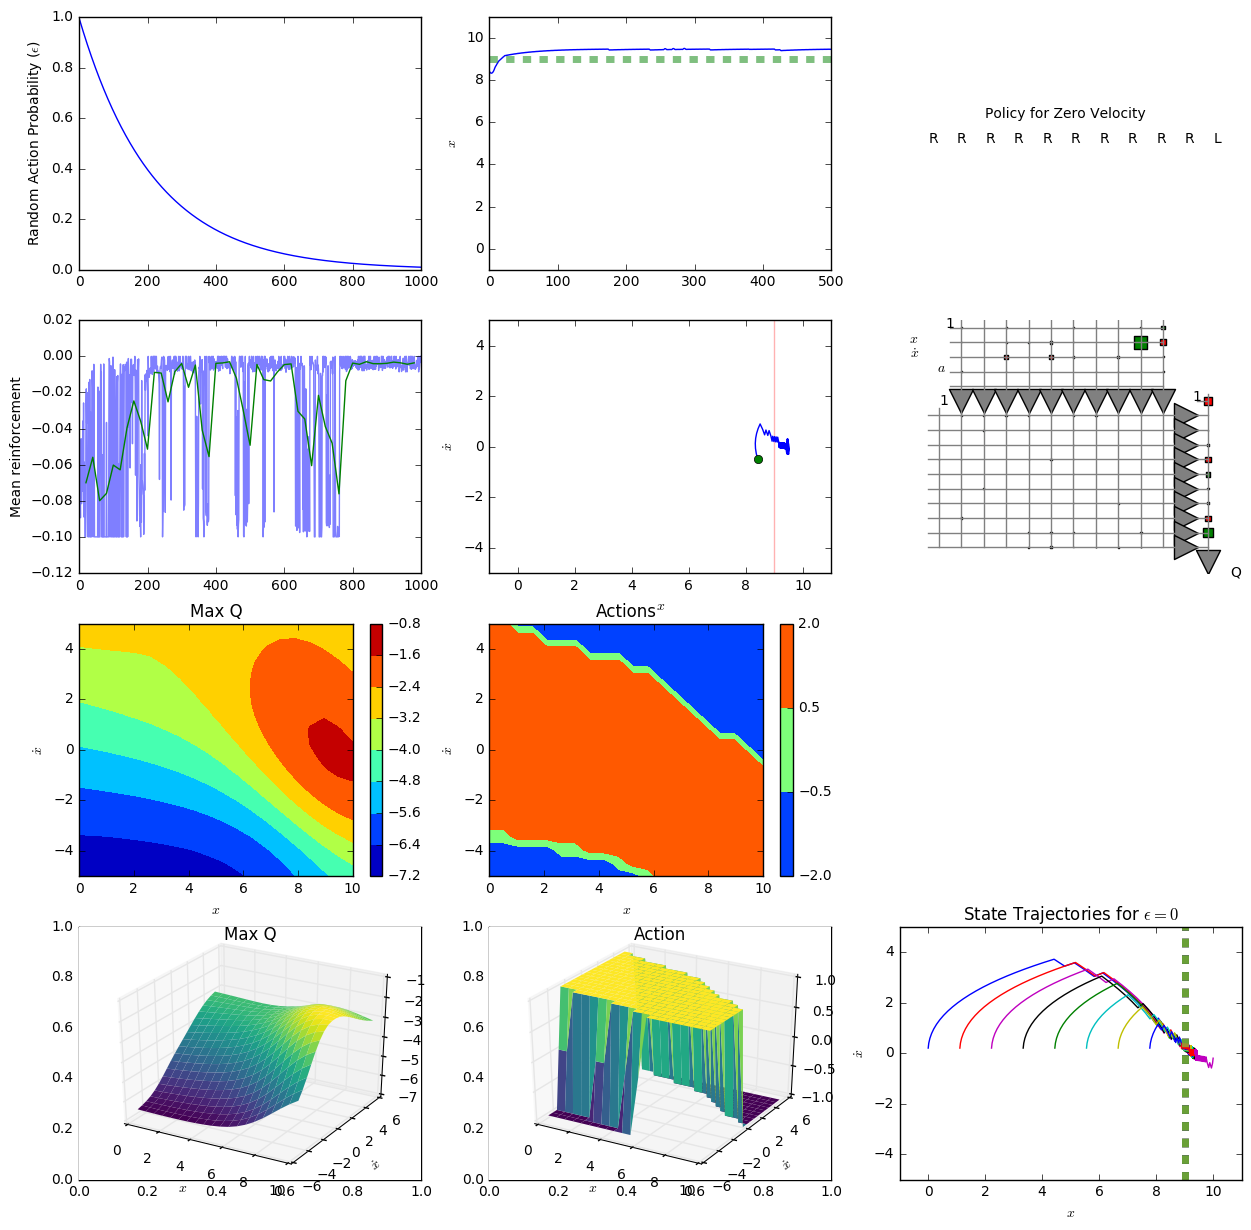

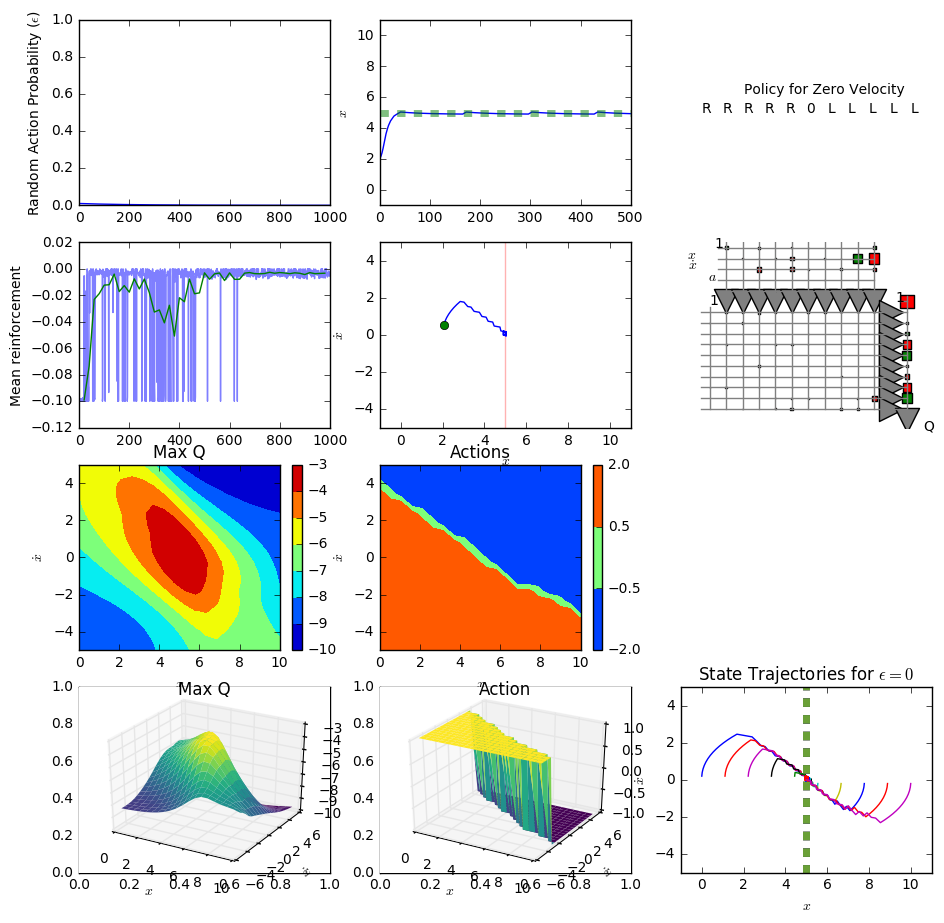

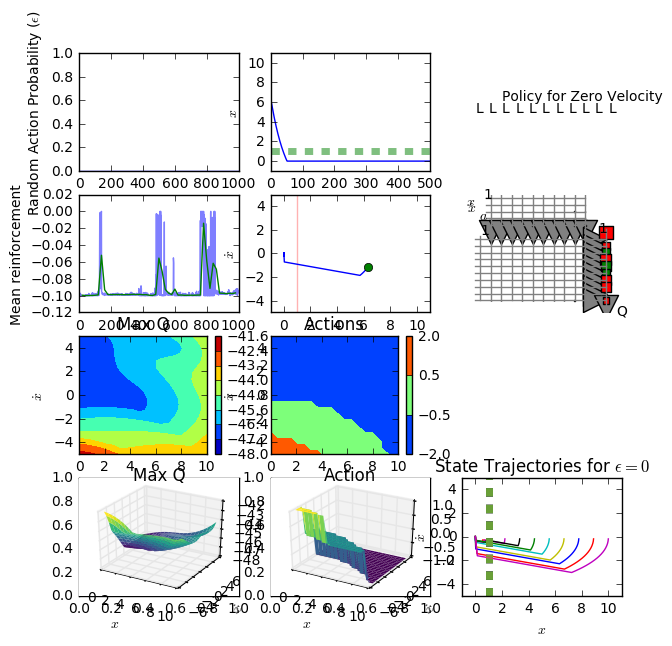

In [6]:
### for Graphs of 1 5 and 9###
gamma = 0.999
nTrials = 1000
nStepsPerTrial = 500
nSCGIterations = 30
finalEpsilon = 0.01
epsilonDecay = np.exp(np.log(finalEpsilon)/(nTrials))  # to produce this final value

nh = [10,10]
qnet = nn.NeuralNetwork([4] + nh + [1])  # [3, 5, 5, 1]
qnet.setInputRanges(( (0, 10), (-3, 3),(0,10), (-1,1)))
fig = plt.figure(figsize=(15,15))

epsilon = 1
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
goal = 9
count = 1
count1 = 0
for i in range(3):
    fig = plt.figure(figsize=(6+goal,6+goal))
    for trial in range(nTrials):

        #Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
        samples = makeSamples(qnet, nStepsPerTrial, count,count1,goal)
        #count = 1
        #count = count + 1
        ns = 2
        na = 2
        X = samples[:, :ns+na]
        R = samples[:, ns+na:ns+na+1]
        nextX = samples[:, ns+na+1:]
        nextQ = qnet.use(nextX)

        qnet.train(X, R + gamma * nextQ, nIterations = nSCGIterations)

        # Decay epsilon
        epsilon *= epsilonDecay
        # epsilon = max(0.01, epsilon)

        # Rest is for plotting
        epsilonTrace[trial] = epsilon
        rtrace[trial] = np.mean(R)
    
    plotStatus(qnet, X, R, trial,epsilonTrace,rtrace,goal)
    testIt(qnet,10,500,goal)
    display(fig);
    goal = goal - 4
        
    # print('Trial',trial,'mean R',np.mean(R))
clear_output(wait=True)

### $Analysis$

By looking at the above graphs i have made following observations.
* First goal state trajectory graph converges better then the last goal graph.
* Last goal takes more time to learn and have a very bad learning as compare to the other too graphs which is mainly because system needs more trials to perform perfect.

### $Overall$ $Analysis$
* By changing the no of hidden layers and no of trials give good and fast results.
* By changing nStepsPerTrial system learns better but it doesn't effect much.
* gamma should be kept high for system to perform good.
* finalepsilon should be less for system to learn fast
* If we use one qnet and train it for goals which are far from eachother then we have to give more no of trials for the goals which comes after to train the network well. 